In [1]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
NUM_EPOCHS = 10   # Allow more time for training
BATCH_SIZE = 32   # Keep the same
HIDDEN_UNITS = 256  # More hidden neurons for better learning
LEARNING_RATE = 0.0001  # Lower LR for more stable learning


In [3]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
from modules.data_setup import create_dataloaders

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir = "data/gd_dataset/test",
    test_dir = "data/gd_dataset/train",
    batch_size=BATCH_SIZE,
    train_transform=train_transform,
    test_transform=test_transform
)

In [5]:
from modules.model_builder_BIC import SimpleCNN

torch.manual_seed(42)

model_3 = SimpleCNN(
    input_shape=3, 
    hidden_units=HIDDEN_UNITS, 
    output_shape=len(class_names)
    ).to(device)



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        """
        Focal Loss implementation.
        
        gamma: Współczynnik tłumienia (zazwyczaj 2.0)
        alpha: Waga dla klas (jeśli dataset jest niezbalansowany)
        reduction: 'mean' lub 'sum' (podobnie jak w CrossEntropyLoss)
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')  # Standardowa CrossEntropy bez redukcji
        pt = torch.exp(-ce_loss)  # Przewidywane prawdopodobieństwo dla poprawnej klasy
        focal_loss = (1 - pt) ** self.gamma * ce_loss  # Wzór na Focal Loss

        if self.alpha is not None:
            alpha_weights = self.alpha[targets]  # Pobranie wag dla prawdziwych klas
            focal_loss *= alpha_weights

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [7]:
# loss_fn = FocalLoss(gamma=1.0, alpha=torch.tensor([0.5, 1.5]).to(device))  # Możesz dostosować wagi

loss_fn = FocalLoss(gamma=1.0)  # Możesz dostosować wagi


In [8]:
# loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(),
                                lr=LEARNING_RATE,
                                weight_decay=0.0001)



In [9]:
from modules import engine
model_3_results = engine.train(
        model=model_3, 
        train_dataloader=train_dataloader, 
        test_dataloader=test_dataloader, 
        optimizer=optimizer,
        loss_fn=loss_fn, 
        epochs=NUM_EPOCHS,
        device=device
    )

c:\Users\gabry\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\gabry\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
 10%|█         | 1/10 [00:10<01:31, 10.15s/it]

Epoch: 1  | Train Loss: 0.4183  | Train Accuracy: 0.4665  | Test Loss: 0.3453  | Test Accuracy: 0.5625


 20%|██        | 2/10 [00:20<01:20, 10.06s/it]

Epoch: 2  | Train Loss: 0.3693  | Train Accuracy: 0.5335  | Test Loss: 0.3446  | Test Accuracy: 0.5625


 30%|███       | 3/10 [00:29<01:08,  9.78s/it]

Epoch: 3  | Train Loss: 0.3376  | Train Accuracy: 0.5982  | Test Loss: 0.3420  | Test Accuracy: 0.5625


 40%|████      | 4/10 [00:38<00:57,  9.55s/it]

Epoch: 4  | Train Loss: 0.3515  | Train Accuracy: 0.5848  | Test Loss: 0.3419  | Test Accuracy: 0.5625


 50%|█████     | 5/10 [00:48<00:47,  9.48s/it]

Epoch: 5  | Train Loss: 0.3613  | Train Accuracy: 0.5982  | Test Loss: 0.3405  | Test Accuracy: 0.5625


 60%|██████    | 6/10 [00:57<00:37,  9.46s/it]

Epoch: 6  | Train Loss: 0.3313  | Train Accuracy: 0.6049  | Test Loss: 0.3392  | Test Accuracy: 0.5625


 70%|███████   | 7/10 [01:06<00:28,  9.43s/it]

Epoch: 7  | Train Loss: 0.2745  | Train Accuracy: 0.7165  | Test Loss: 0.3374  | Test Accuracy: 0.5687


 80%|████████  | 8/10 [01:16<00:18,  9.38s/it]

Epoch: 8  | Train Loss: 0.2735  | Train Accuracy: 0.7031  | Test Loss: 0.3352  | Test Accuracy: 0.5875


 90%|█████████ | 9/10 [01:25<00:09,  9.40s/it]

Epoch: 9  | Train Loss: 0.3007  | Train Accuracy: 0.7210  | Test Loss: 0.3324  | Test Accuracy: 0.5938


100%|██████████| 10/10 [01:35<00:00,  9.55s/it]

Epoch: 10  | Train Loss: 0.2528  | Train Accuracy: 0.7679  | Test Loss: 0.3297  | Test Accuracy: 0.5938


In [10]:
# from modules.utils import save_model

# save_model(
#     model=model_3, 
#     target_directory="models", 
#     model_name="model_3_SimpleCNN_69TESTACC.pth",
#     )

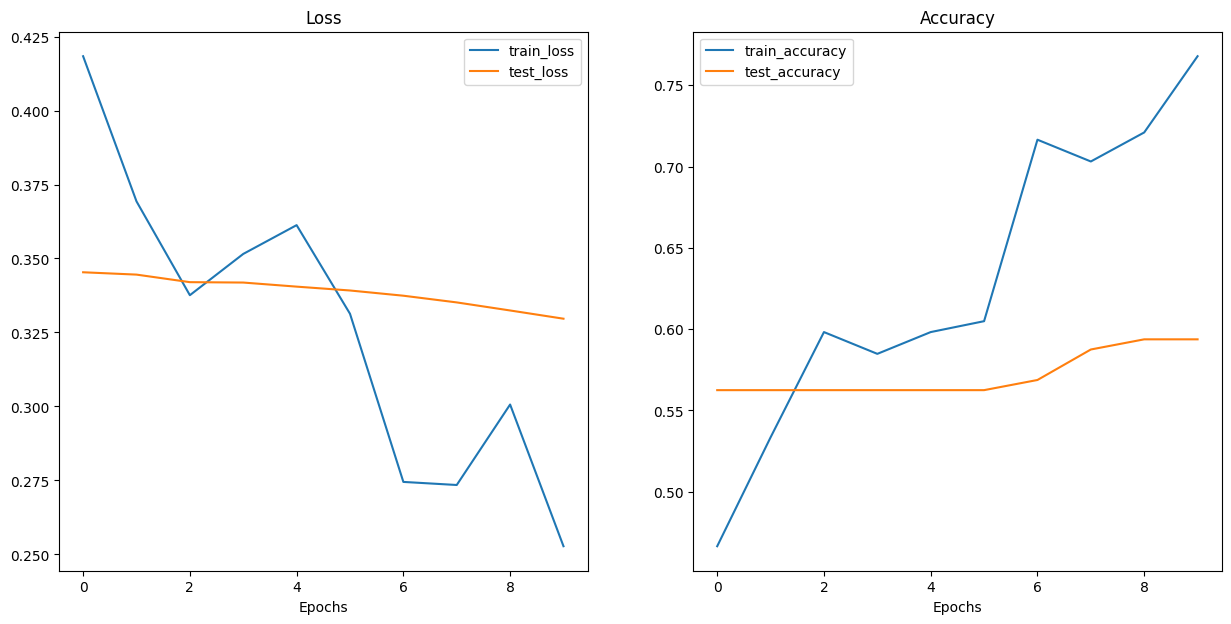

In [11]:
from modules.plots import plot_loss_curves

plot_loss_curves(model_3_results)

In [12]:
import os
import random

def get_random_photo(directory):
    """Returns a random .jpg file path from the given directory."""
    jpg_files = [f for f in os.listdir(directory) if f.lower().endswith('.jpg')]
    
    if not jpg_files:
        return None  # No .jpg files found
    
    return os.path.join(directory, random.choice(jpg_files))


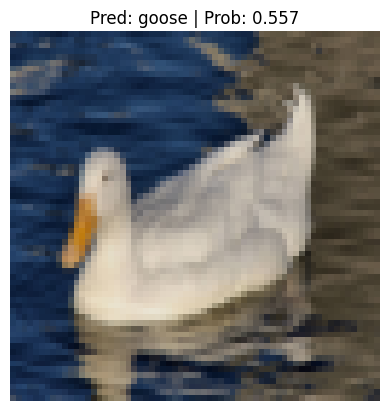

In [26]:
from modules.plots import pred_and_plot_image
import torch
import torchvision.transforms as transforms

# Get a random image from the test dataset
custom_image_path = get_random_photo("data/gd_dataset/train/duck/")  

# Ensure the image is resized to match model input size
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Run prediction and plot results
pred_and_plot_image(model=model_3,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

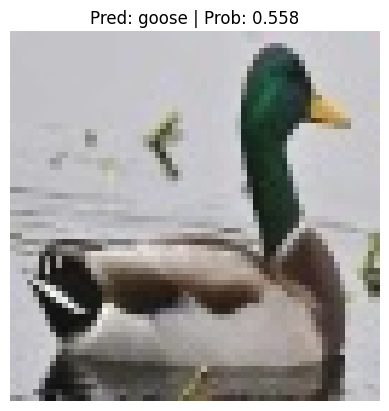

: 

In [ ]:
from modules.plots import pred_and_plot_image
import torch

# custom_image_path = "data/my_goose2.jpg"
# custom_image_path = "data/my_ducky2.jpg"
custom_image_path = get_random_photo("data/gd_dataset/test/duck/")
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

pred_and_plot_image(model=model_3,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

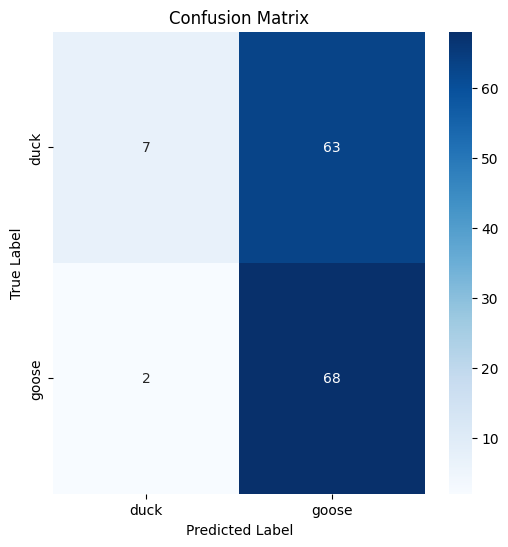

In [15]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def evaluate_model(model, dataloader, class_names, device):
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Wywołaj funkcję
evaluate_model(model_3, test_dataloader, class_names, device)
